In [1]:
# Command to reload all modules before executing the code
%load_ext autoreload 
%autoreload 2

In [2]:
# ML libraries
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Utils
import os
import sys
from collections import defaultdict
from tqdm import tqdm
import warnings
from typing import List, Dict, Any, Tuple, Union, Optional, Callable, TypeVar
# Project modules
pass

warnings.filterwarnings('ignore')

C:\Users\timot\AppData\Local\Temp\ipykernel_16088\3779753175.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Comparison of the distributions of HOME and AWAY

In this notebook, we unsure out of curiosty, we will compare the distributions of the HOME and AWAY teams in the dataset. We will use the `seaborn` library to visualize the distributions of the HOME and AWAY teams.

## Team features

In [3]:
from data_loading import load_dataframe_teamfeatures
df_teamfeatures = load_dataframe_teamfeatures('train')

We plot the top 10 metrics season averaged distributions for HOME and AWAY, in terms of difference between the two distributions.

HOME_ID ['']
Missing season_average for HOME_ID
HOME_LEAGUE ['']
Missing season_average for HOME_LEAGUE
HOME_TEAM_NAME ['']
Missing season_average for HOME_TEAM_NAME
HOME_TEAM_SHOTS_TOTAL ['season_sum', 'season_average', 'season_std', '5_last_match_sum', '5_last_match_average', '5_last_match_std']
HOME_TEAM_SHOTS_INSIDEBOX ['season_sum', 'season_average', 'season_std', '5_last_match_sum', '5_last_match_average', '5_last_match_std']
HOME_TEAM_SHOTS_OFF_TARGET ['season_sum', 'season_average', 'season_std', '5_last_match_sum', '5_last_match_average', '5_last_match_std']
HOME_TEAM_SHOTS_ON_TARGET ['season_sum', 'season_average', 'season_std', '5_last_match_sum', '5_last_match_average', '5_last_match_std']
HOME_TEAM_SHOTS_OUTSIDEBOX ['season_sum', 'season_average', 'season_std', '5_last_match_sum', '5_last_match_average', '5_last_match_std']
HOME_TEAM_PASSES ['season_sum', 'season_average', 'season_std', '5_last_match_sum', '5_last_match_average', '5_last_match_std']
HOME_TEAM_SUCCESSFUL_PA

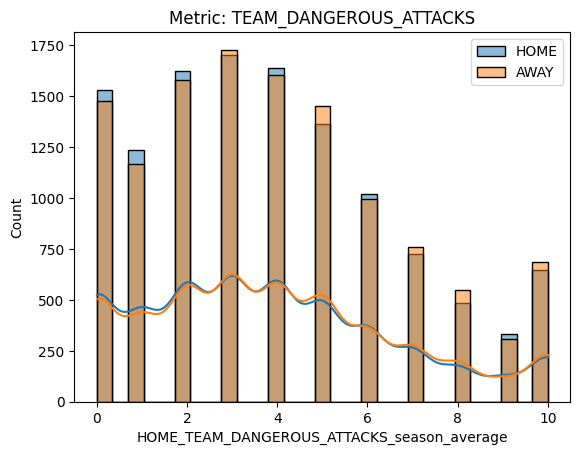

TEAM_SHOTS_ON_TARGET HOME distribution vs AWAY distribution difference (loss_value_normalized) : 1.361918715180237 (loss = l1_loss)


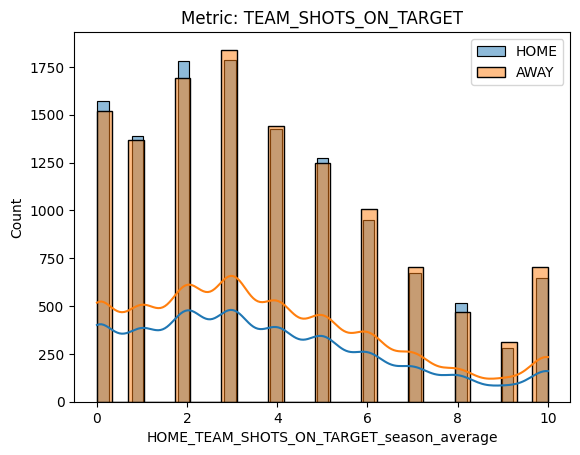

TEAM_SHOTS_TOTAL HOME distribution vs AWAY distribution difference (loss_value_normalized) : 1.2985345622617173 (loss = l1_loss)


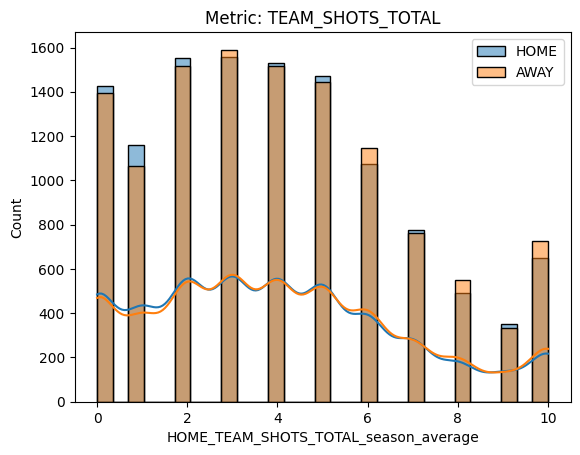

TEAM_GAME_LOST HOME distribution vs AWAY distribution difference (loss_value_normalized) : 1.244592813839663 (loss = l1_loss)


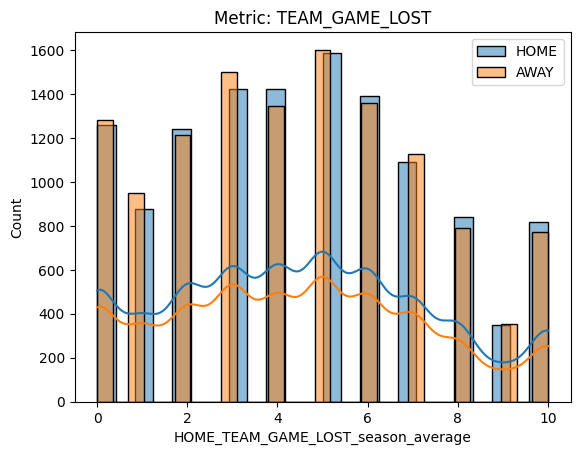

TEAM_SHOTS_OUTSIDEBOX HOME distribution vs AWAY distribution difference (loss_value_normalized) : 1.181970194241471 (loss = l1_loss)


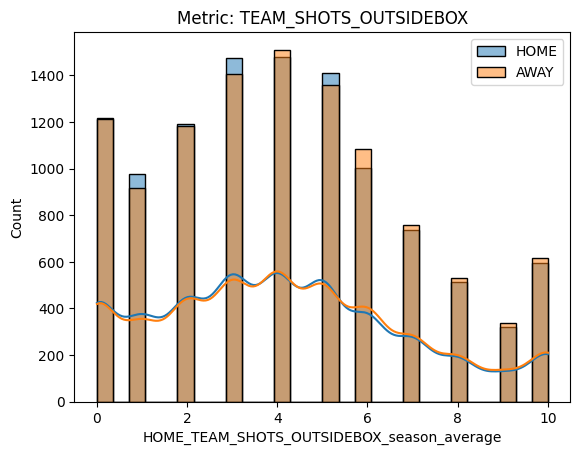

TEAM_SHOTS_INSIDEBOX HOME distribution vs AWAY distribution difference (loss_value_normalized) : 1.167074201025335 (loss = l1_loss)


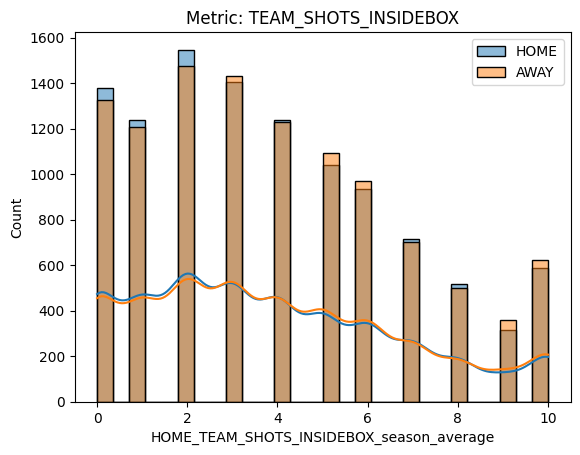

TEAM_GOALS HOME distribution vs AWAY distribution difference (loss_value_normalized) : 1.1577247148183165 (loss = l1_loss)


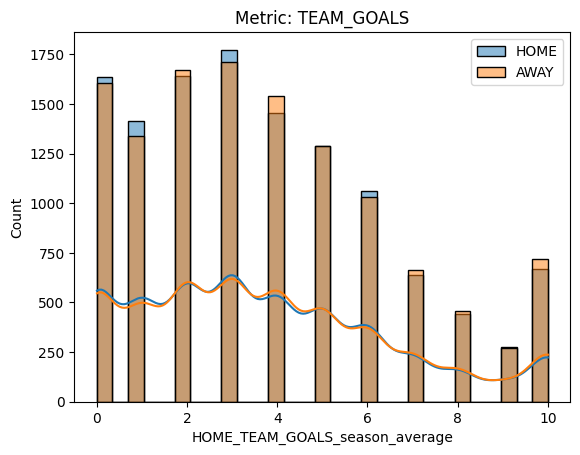

TEAM_GAME_WON HOME distribution vs AWAY distribution difference (loss_value_normalized) : 1.1282246762740809 (loss = l1_loss)


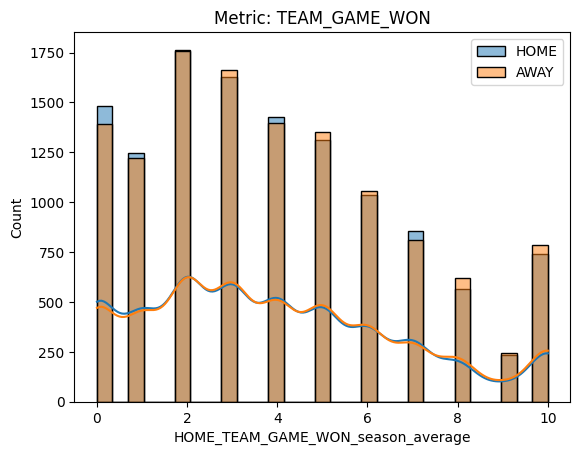

TEAM_PENALTIES HOME distribution vs AWAY distribution difference (loss_value_normalized) : 1.0237634474561594 (loss = l1_loss)


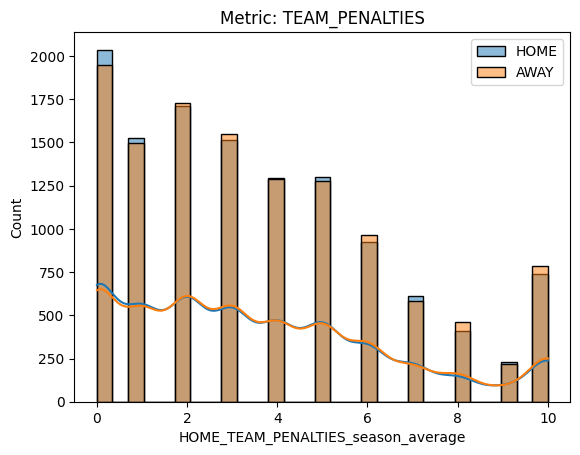

TEAM_INJURIES HOME distribution vs AWAY distribution difference (loss_value_normalized) : 0.9714387661562397 (loss = l1_loss)


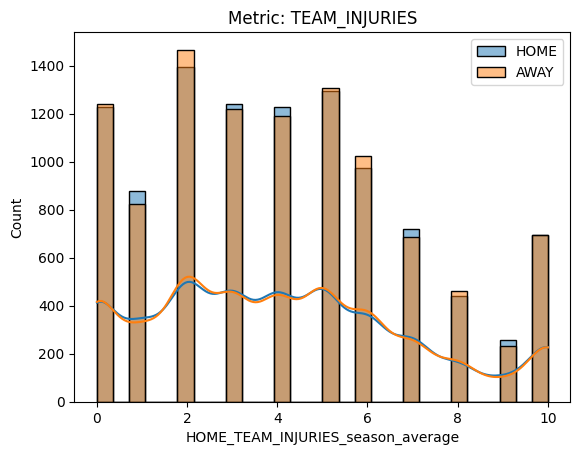

In [6]:
from data_analysis import get_metrics_names_to_fn_names, compute_distribution_difference, loss_name_to_loss_fn

column_names_to_fn_names = get_metrics_names_to_fn_names(df_teamfeatures)
metric_name_side_agnostic_to_loss_name_to_loss_values : Dict[str, Dict[str, float]] = {}
for metric_name, list_fn_names in column_names_to_fn_names.items():
    print(metric_name, list_fn_names)
    
    # Skip metrics that doesnt have the season_average function (i.e. non-aggregated metrics I believe)
    if 'season_average' not in list_fn_names:
        print(f"Missing season_average for {metric_name}")
        continue
    
    # Skip AWAY metrics (we will compare them to the HOME metrics)
    if metric_name.startswith('AWAY_'):
        continue
    
    assert metric_name.startswith('HOME_'), f"Unexpected metric name {metric_name}"
    
    # Compute the distribution difference
    metric_name_side_agnostic = metric_name[len('HOME_'):]
    column_name_home = f"HOME_{metric_name_side_agnostic}_season_average"
    column_name_away = f"AWAY_{metric_name_side_agnostic}_season_average"
    metric_name_side_agnostic_to_loss_name_to_loss_values[metric_name_side_agnostic] = compute_distribution_difference(
        feature_serie1=df_teamfeatures[column_name_home],
        feature_serie2=df_teamfeatures[column_name_away],
        n_monte_carlo=100,
        n_value_max=10,
        normalization_method='mc_estimated_loss',
        )

# Print top differences
LOSS_NAME = 'l1_loss'
assert LOSS_NAME in loss_name_to_loss_fn.keys(), f"{LOSS_NAME} not in {loss_name_to_loss_fn.keys()}"
LOSS_STATISTIC = 'loss_value_normalized'
assert LOSS_STATISTIC in ['loss_value', 'loss_value_normalized', 'estimated_typical_loss_value']
n_top_metrics_to_plot = 10

for metric_name_side_agnostic, loss_name_to_loss_values in sorted(metric_name_side_agnostic_to_loss_name_to_loss_values.items(), key = lambda x : x[1][LOSS_NAME][LOSS_STATISTIC], reverse=True)[:n_top_metrics_to_plot]:
    print(f"{metric_name_side_agnostic} HOME distribution vs AWAY distribution difference ({LOSS_STATISTIC}) : {loss_name_to_loss_values[LOSS_NAME][LOSS_STATISTIC]} (loss = {LOSS_NAME})")
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {metric_name_side_agnostic}")
    column_name_home = f"HOME_{metric_name_side_agnostic}_season_average"
    column_name_away = f"AWAY_{metric_name_side_agnostic}_season_average"
    sns.histplot(df_teamfeatures[column_name_home], kde=True, label="HOME")
    sns.histplot(df_teamfeatures[column_name_away], kde=True, label="AWAY")
    plt.legend()
    plt.show()

Below, we plot not the tops, but all double distributions of the team features.

Missing season_average for HOME_ID
Missing season_average for HOME_LEAGUE
Missing season_average for HOME_TEAM_NAME


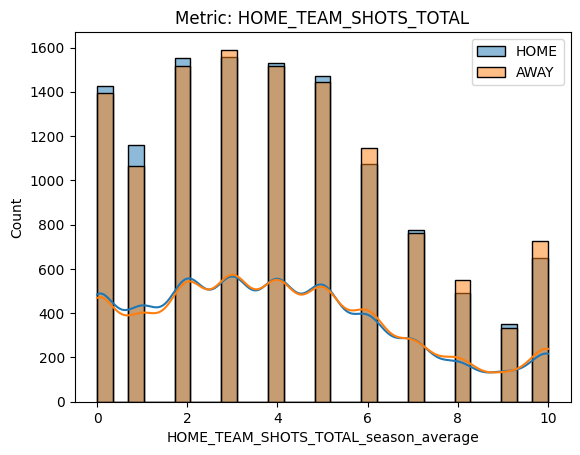

Metric: HOME_TEAM_SHOTS_TOTAL
Differences: {'l1_loss': {'loss_value': 0.003512672577260764, 'estimated_typical_loss_value': 0.0027057702112566785, 'loss_value_normalized': 1.2982154074454963}, 'l2_loss': {'loss_value': 2.118396285396333e-05, 'estimated_typical_loss_value': 1.377489119608506e-05, 'loss_value_normalized': 1.5378678896311364}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04377872821451027, 'estimated_typical_loss_value': 0.030547564301996386, 'loss_value_normalized': 1.4331331880247113}}


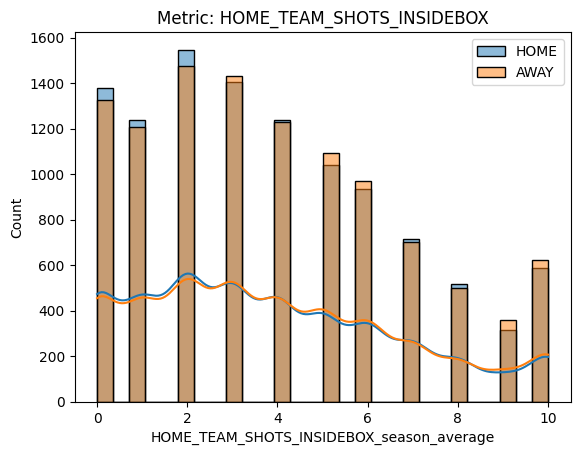

Metric: HOME_TEAM_SHOTS_INSIDEBOX
Differences: {'l1_loss': {'loss_value': 0.003087637508480163, 'estimated_typical_loss_value': 0.0025593166485631735, 'loss_value_normalized': 1.2064304392398364}, 'l2_loss': {'loss_value': 1.4549347049364951e-05, 'estimated_typical_loss_value': 1.205587814167412e-05, 'loss_value_normalized': 1.2068259879637944}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.037920479184571976, 'estimated_typical_loss_value': 0.03156076811321019, 'loss_value_normalized': 1.2015068533360433}}


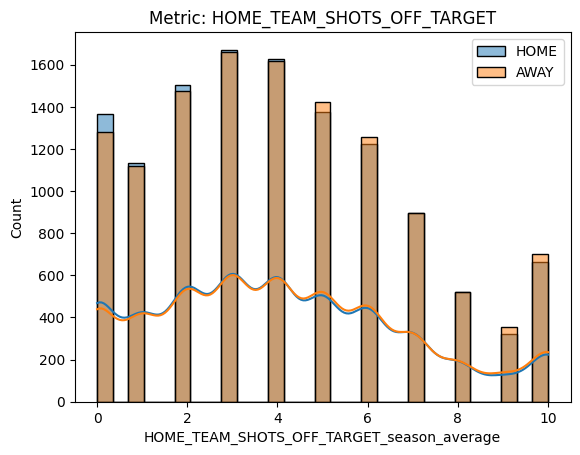

Metric: HOME_TEAM_SHOTS_OFF_TARGET
Differences: {'l1_loss': {'loss_value': 0.002275867674550921, 'estimated_typical_loss_value': 0.0025547353564910258, 'loss_value_normalized': 0.8908428298720803}, 'l2_loss': {'loss_value': 9.772961826513777e-06, 'estimated_typical_loss_value': 1.434269835628578e-05, 'loss_value_normalized': 0.6813893441522051}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.027263971270832063, 'estimated_typical_loss_value': 0.030719766944626938, 'loss_value_normalized': 0.8875057978133681}}


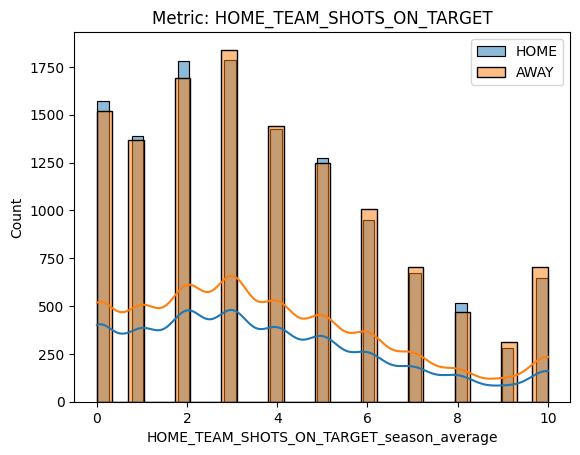

Metric: HOME_TEAM_SHOTS_ON_TARGET
Differences: {'l1_loss': {'loss_value': 0.0035621641995107578, 'estimated_typical_loss_value': 0.0025458683395771908, 'loss_value_normalized': 1.3991941940336314}, 'l2_loss': {'loss_value': 1.6979674864772177e-05, 'estimated_typical_loss_value': 1.368629069653692e-05, 'loss_value_normalized': 1.2406338021735221}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04785625413345238, 'estimated_typical_loss_value': 0.032988689900407445, 'loss_value_normalized': 1.4506867134745167}}


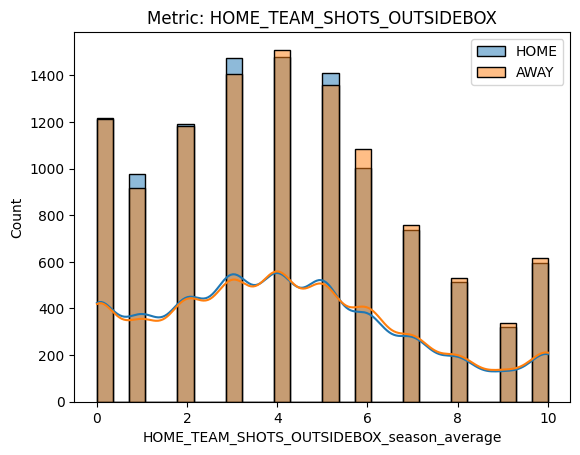

Metric: HOME_TEAM_SHOTS_OUTSIDEBOX
Differences: {'l1_loss': {'loss_value': 0.003145824331566365, 'estimated_typical_loss_value': 0.0025916812602986713, 'loss_value_normalized': 1.2138160582306958}, 'l2_loss': {'loss_value': 1.5390268088897097e-05, 'estimated_typical_loss_value': 1.3581570095254286e-05, 'loss_value_normalized': 1.1331729675365882}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.03346435578747889, 'estimated_typical_loss_value': 0.03177022166161869, 'loss_value_normalized': 1.0533245925667125}}


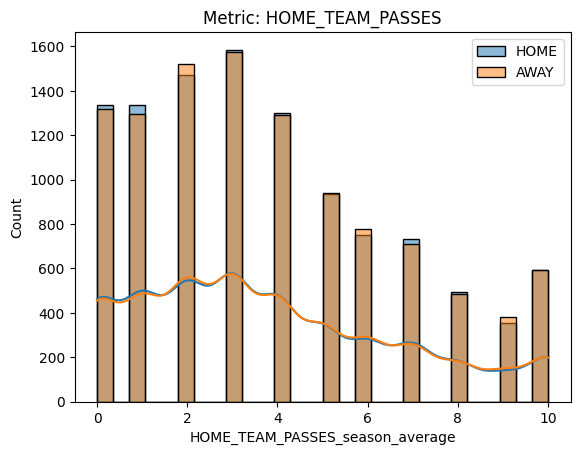

Metric: HOME_TEAM_PASSES
Differences: {'l1_loss': {'loss_value': 0.001758573860431888, 'estimated_typical_loss_value': 0.0025365579718176646, 'loss_value_normalized': 0.693291412997576}, 'l2_loss': {'loss_value': 5.844543937345799e-06, 'estimated_typical_loss_value': 1.4150734611264243e-05, 'loss_value_normalized': 0.4130205319942702}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.020823023552125404, 'estimated_typical_loss_value': 0.03197435938381387, 'loss_value_normalized': 0.6512413056402417}}


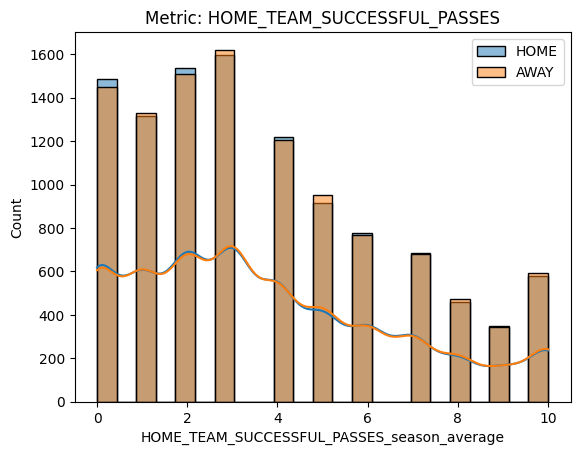

Metric: HOME_TEAM_SUCCESSFUL_PASSES
Differences: {'l1_loss': {'loss_value': 0.001504185691646393, 'estimated_typical_loss_value': 0.002711681555865902, 'loss_value_normalized': 0.5547058755451648}, 'l2_loss': {'loss_value': 3.2263638887725678e-06, 'estimated_typical_loss_value': 1.257179346916769e-05, 'loss_value_normalized': 0.2566351329767099}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.01748043460771779, 'estimated_typical_loss_value': 0.03175705345871858, 'loss_value_normalized': 0.5504425853122904}}


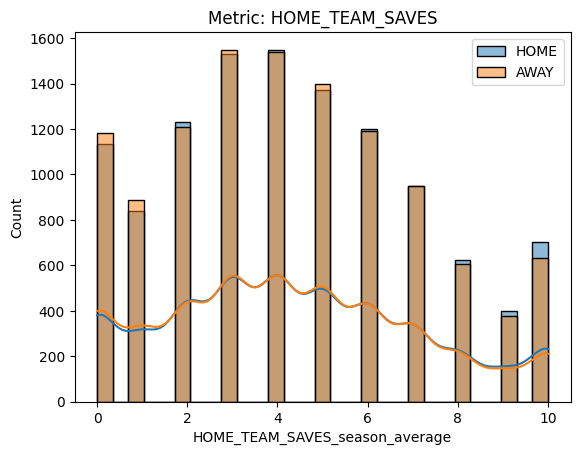

Metric: HOME_TEAM_SAVES
Differences: {'l1_loss': {'loss_value': 0.0021393795259352995, 'estimated_typical_loss_value': 0.0026720755469841063, 'loss_value_normalized': 0.8006433531977706}, 'l2_loss': {'loss_value': 1.150840558985e-05, 'estimated_typical_loss_value': 1.2401643513080466e-05, 'loss_value_normalized': 0.9279742299885989}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.02500709093181032, 'estimated_typical_loss_value': 0.02997796409151771, 'loss_value_normalized': 0.8341824299831593}}


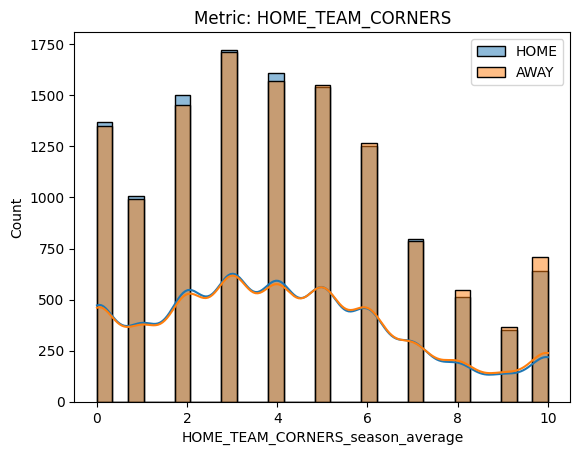

Metric: HOME_TEAM_CORNERS
Differences: {'l1_loss': {'loss_value': 0.0021282570461565744, 'estimated_typical_loss_value': 0.0027354747179180244, 'loss_value_normalized': 0.7780210989397199}, 'l2_loss': {'loss_value': 7.073814492545204e-06, 'estimated_typical_loss_value': 1.2568370049648815e-05, 'loss_value_normalized': 0.5628267201297027}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.029617935968981216, 'estimated_typical_loss_value': 0.03201845599758486, 'loss_value_normalized': 0.9250269897841132}}


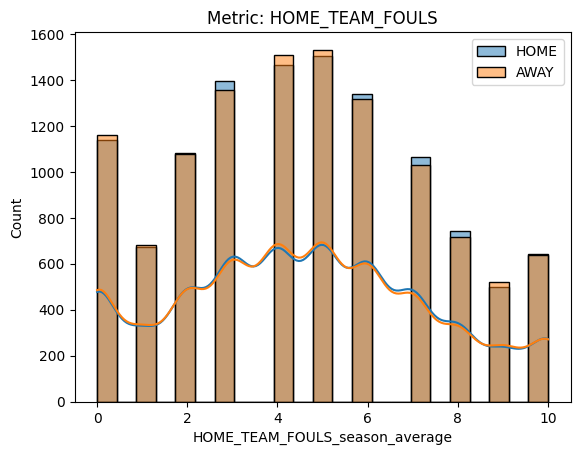

Metric: HOME_TEAM_FOULS
Differences: {'l1_loss': {'loss_value': 0.0019496506544771962, 'estimated_typical_loss_value': 0.0027421249806034, 'loss_value_normalized': 0.7109999246088415}, 'l2_loss': {'loss_value': 5.287000269979604e-06, 'estimated_typical_loss_value': 1.221531339526718e-05, 'loss_value_normalized': 0.43281740703696936}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.0203962282931641, 'estimated_typical_loss_value': 0.02986802148346595, 'loss_value_normalized': 0.6828784526104179}}


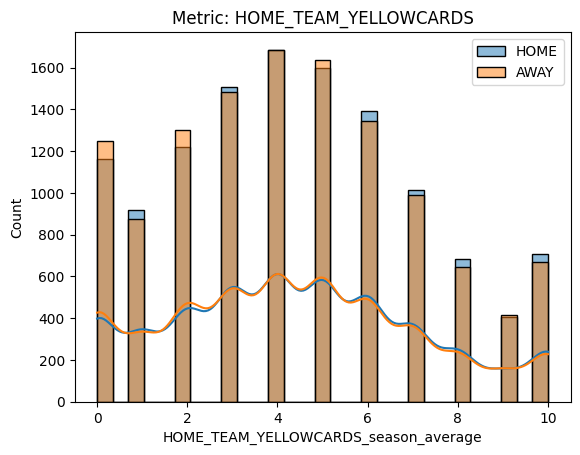

Metric: HOME_TEAM_YELLOWCARDS
Differences: {'l1_loss': {'loss_value': 0.0024985585239285023, 'estimated_typical_loss_value': 0.002628922731336777, 'loss_value_normalized': 0.9504115484816106}, 'l2_loss': {'loss_value': 9.563316235502389e-06, 'estimated_typical_loss_value': 1.1887469925342112e-05, 'loss_value_normalized': 0.8044871024183502}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.027983882305816887, 'estimated_typical_loss_value': 0.030869096522893668, 'loss_value_normalized': 0.9065338949930977}}


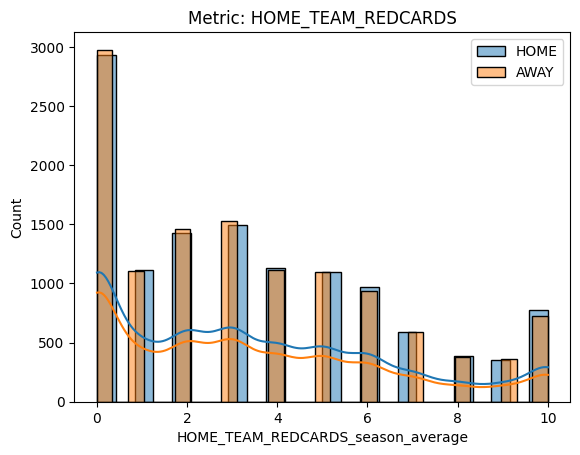

Metric: HOME_TEAM_REDCARDS
Differences: {'l1_loss': {'loss_value': 0.0016449440200357122, 'estimated_typical_loss_value': 0.0025380358079699714, 'loss_value_normalized': 0.6481169473141769}, 'l2_loss': {'loss_value': 4.5923088691088945e-06, 'estimated_typical_loss_value': 1.2857582933003013e-05, 'loss_value_normalized': 0.357167353534387}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.019318427579795416, 'estimated_typical_loss_value': 0.03425779850646147, 'loss_value_normalized': 0.563913281705816}}


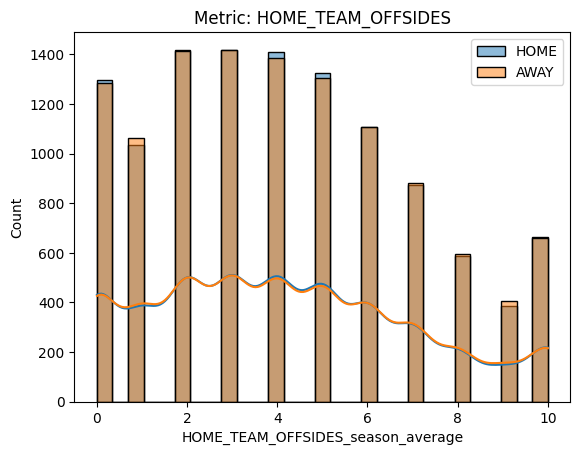

Metric: HOME_TEAM_OFFSIDES
Differences: {'l1_loss': {'loss_value': 0.0009046377254963875, 'estimated_typical_loss_value': 0.002653011460619361, 'loss_value_normalized': 0.34098523090628446}, 'l2_loss': {'loss_value': 1.408876015301168e-06, 'estimated_typical_loss_value': 1.2278544554380717e-05, 'loss_value_normalized': 0.11474291672240856}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.01269842964503049, 'estimated_typical_loss_value': 0.03058657276585626, 'loss_value_normalized': 0.4151635340853106}}


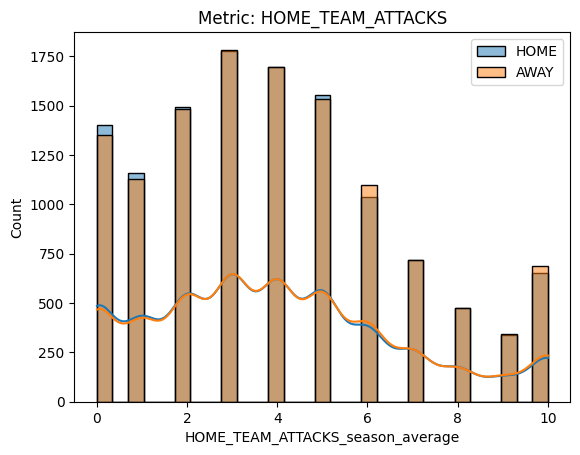

Metric: HOME_TEAM_ATTACKS
Differences: {'l1_loss': {'loss_value': 0.0016551764905824878, 'estimated_typical_loss_value': 0.0025590210813327134, 'loss_value_normalized': 0.6468006468005899}, 'l2_loss': {'loss_value': 7.006598615296805e-06, 'estimated_typical_loss_value': 1.2426340181609606e-05, 'loss_value_normalized': 0.5638505394807265}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.017736956867216273, 'estimated_typical_loss_value': 0.031239742136078455, 'loss_value_normalized': 0.5677689908564232}}


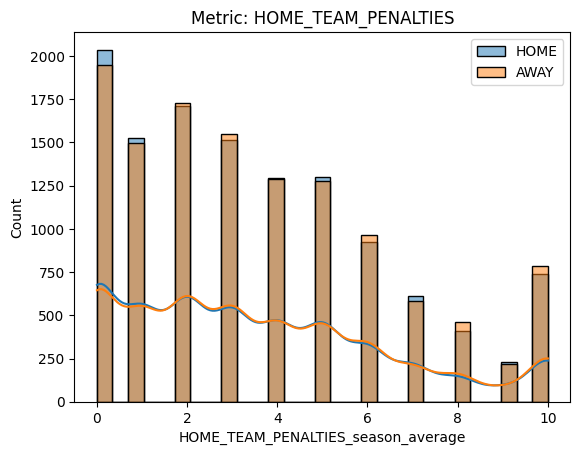

Metric: HOME_TEAM_PENALTIES
Differences: {'l1_loss': {'loss_value': 0.0027079618517723844, 'estimated_typical_loss_value': 0.002638380882711533, 'loss_value_normalized': 1.0263726020441422}, 'l2_loss': {'loss_value': 1.375706441380624e-05, 'estimated_typical_loss_value': 1.243703086010714e-05, 'loss_value_normalized': 1.1061373545101998}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.03610047648802557, 'estimated_typical_loss_value': 0.03512679311484112, 'loss_value_normalized': 1.027719108032462}}


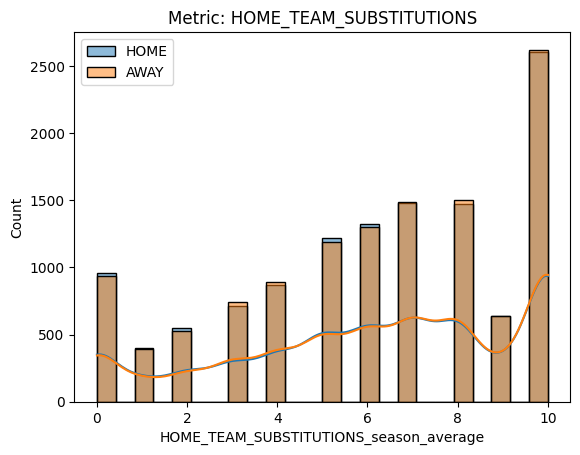

Metric: HOME_TEAM_SUBSTITUTIONS
Differences: {'l1_loss': {'loss_value': 0.0015158946007401116, 'estimated_typical_loss_value': 0.002625375924571242, 'loss_value_normalized': 0.5774009682013629}, 'l2_loss': {'loss_value': 2.9798740376510132e-06, 'estimated_typical_loss_value': 1.3194627593634953e-05, 'loss_value_normalized': 0.22583995012017985}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.018681214684247563, 'estimated_typical_loss_value': 0.02858041913702629, 'loss_value_normalized': 0.6536368341794425}}


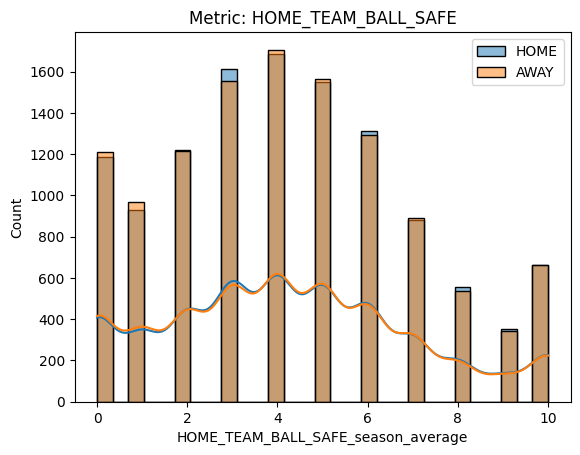

Metric: HOME_TEAM_BALL_SAFE
Differences: {'l1_loss': {'loss_value': 0.0014537901037647112, 'estimated_typical_loss_value': 0.0025415826147355044, 'loss_value_normalized': 0.5720019075263765}, 'l2_loss': {'loss_value': 4.606020232351123e-06, 'estimated_typical_loss_value': 1.4627442776267974e-05, 'loss_value_normalized': 0.3148889592481713}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.01409131661680707, 'estimated_typical_loss_value': 0.030730666723428505, 'loss_value_normalized': 0.4585424957950555}}


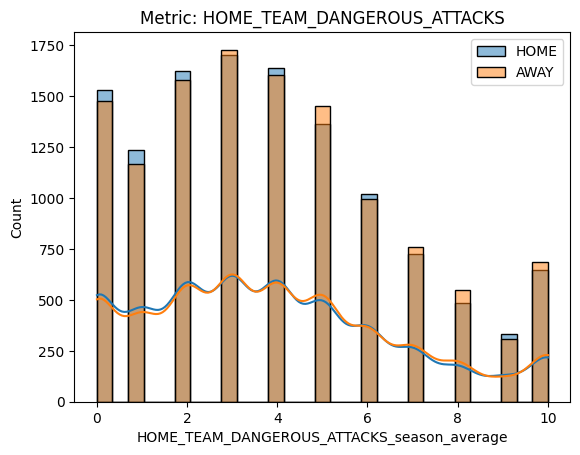

Metric: HOME_TEAM_DANGEROUS_ATTACKS
Differences: {'l1_loss': {'loss_value': 0.0036945903807644852, 'estimated_typical_loss_value': 0.0027084303163308287, 'loss_value_normalized': 1.36410760080744}, 'l2_loss': {'loss_value': 2.0783159479147245e-05, 'estimated_typical_loss_value': 1.2951252495838743e-05, 'loss_value_normalized': 1.6047219746096824}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04615355719280668, 'estimated_typical_loss_value': 0.03154758192397491, 'loss_value_normalized': 1.462982402392352}}


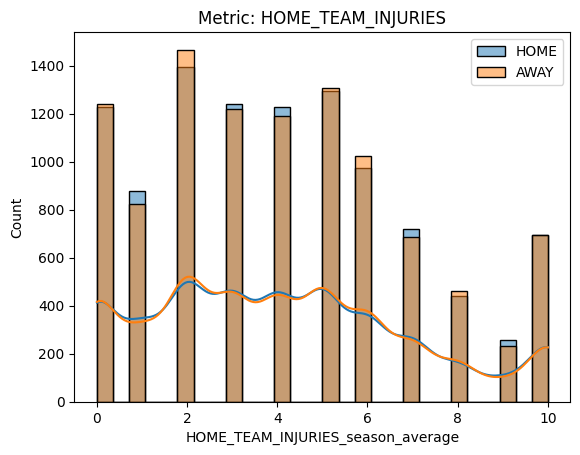

Metric: HOME_TEAM_INJURIES
Differences: {'l1_loss': {'loss_value': 0.002696538810890781, 'estimated_typical_loss_value': 0.0027078391818699055, 'loss_value_normalized': 0.9958267939045249}, 'l2_loss': {'loss_value': 1.089669850985587e-05, 'estimated_typical_loss_value': 1.335117996763318e-05, 'loss_value_normalized': 0.816159960100242}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.03288565008609457, 'estimated_typical_loss_value': 0.03224729981534886, 'loss_value_normalized': 1.0197954642528442}}


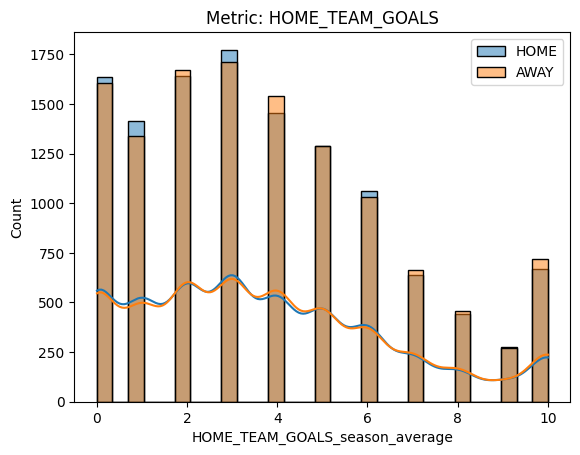

Metric: HOME_TEAM_GOALS
Differences: {'l1_loss': {'loss_value': 0.0030157662485494, 'estimated_typical_loss_value': 0.0026608439922265813, 'loss_value_normalized': 1.1333870972366065}, 'l2_loss': {'loss_value': 1.6524838774177863e-05, 'estimated_typical_loss_value': 1.3279984853638899e-05, 'loss_value_normalized': 1.2443416883396166}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.030937152274070324, 'estimated_typical_loss_value': 0.03318916063870087, 'loss_value_normalized': 0.9321462694056578}}


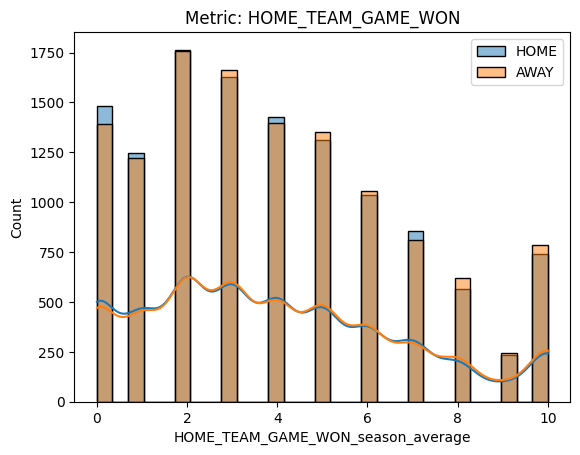

Metric: HOME_TEAM_GAME_WON
Differences: {'l1_loss': {'loss_value': 0.002957595474878924, 'estimated_typical_loss_value': 0.002588577804378828, 'loss_value_normalized': 1.1425561441018357}, 'l2_loss': {'loss_value': 1.505499087395672e-05, 'estimated_typical_loss_value': 1.3782662958992817e-05, 'loss_value_normalized': 1.0923136492930925}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.0360049260722222, 'estimated_typical_loss_value': 0.03282194592190924, 'loss_value_normalized': 1.0969771919643563}}


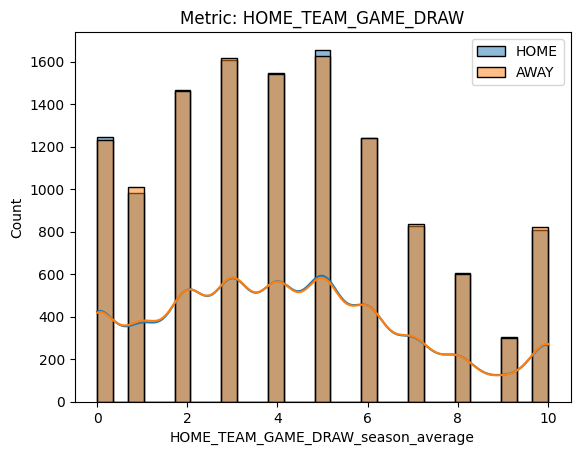

Metric: HOME_TEAM_GAME_DRAW
Differences: {'l1_loss': {'loss_value': 0.0006214488636363646, 'estimated_typical_loss_value': 0.002741090495296787, 'loss_value_normalized': 0.2267159237181726}, 'l2_loss': {'loss_value': 8.404856980449027e-07, 'estimated_typical_loss_value': 1.3801053328408247e-05, 'loss_value_normalized': 0.06090011233427486}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.007256454509132913, 'estimated_typical_loss_value': 0.03055621996556669, 'loss_value_normalized': 0.23747880193656287}}


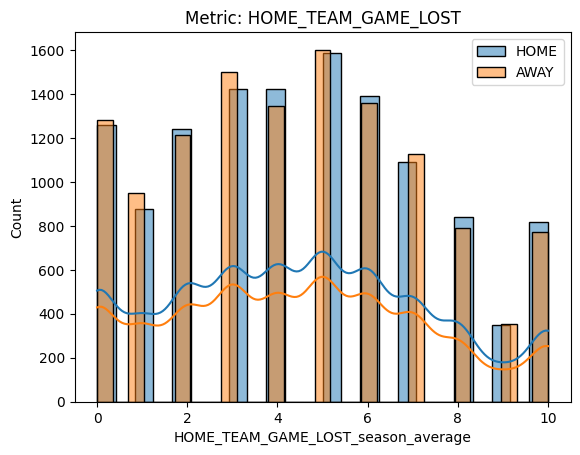

Metric: HOME_TEAM_GAME_LOST
Differences: {'l1_loss': {'loss_value': 0.0034754573553987898, 'estimated_typical_loss_value': 0.002602912815056196, 'loss_value_normalized': 1.3352185041677853}, 'l2_loss': {'loss_value': 1.7848305446369575e-05, 'estimated_typical_loss_value': 1.244101884354667e-05, 'loss_value_normalized': 1.434633744270003}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.03390751970325766, 'estimated_typical_loss_value': 0.02974653663143447, 'loss_value_normalized': 1.139881261586125}}


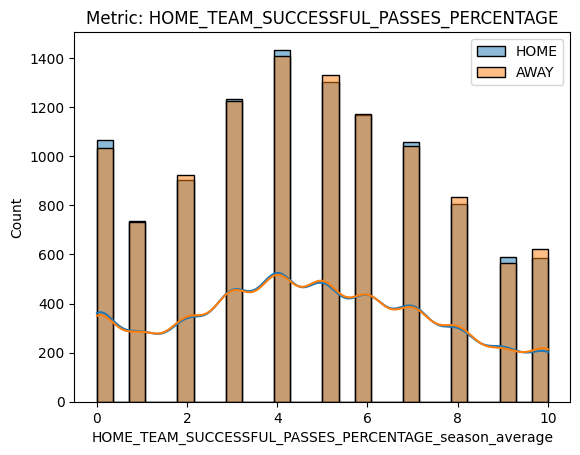

Metric: HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE
Differences: {'l1_loss': {'loss_value': 0.001849974177102147, 'estimated_typical_loss_value': 0.0027570511257416887, 'loss_value_normalized': 0.6709974145308338}, 'l2_loss': {'loss_value': 4.512349481142639e-06, 'estimated_typical_loss_value': 1.3541185756929877e-05, 'loss_value_normalized': 0.33323148814788195}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.02115171856655536, 'estimated_typical_loss_value': 0.02992921368767249, 'loss_value_normalized': 0.7067248337121319}}


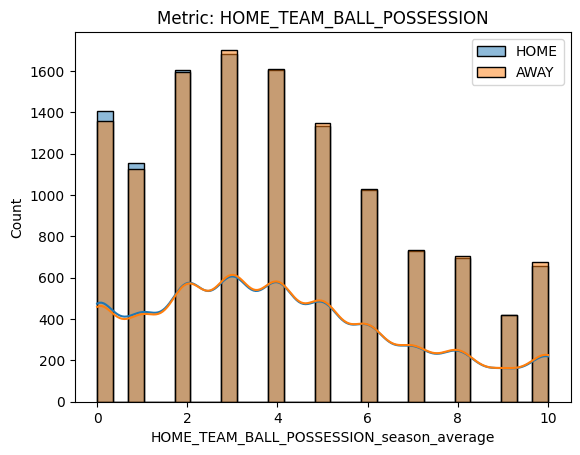

Metric: HOME_TEAM_BALL_POSSESSION
Differences: {'l1_loss': {'loss_value': 0.0012809246807706566, 'estimated_typical_loss_value': 0.002640597636939992, 'loss_value_normalized': 0.48508892943452186}, 'l2_loss': {'loss_value': 4.356278389699268e-06, 'estimated_typical_loss_value': 1.4458397924025429e-05, 'loss_value_normalized': 0.3012974475127404}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.011301522162954785, 'estimated_typical_loss_value': 0.03138232895083684, 'loss_value_normalized': 0.3601237556543215}}
Missing season_average for AWAY_ID
Missing season_average for AWAY_LEAGUE
Missing season_average for AWAY_TEAM_NAME


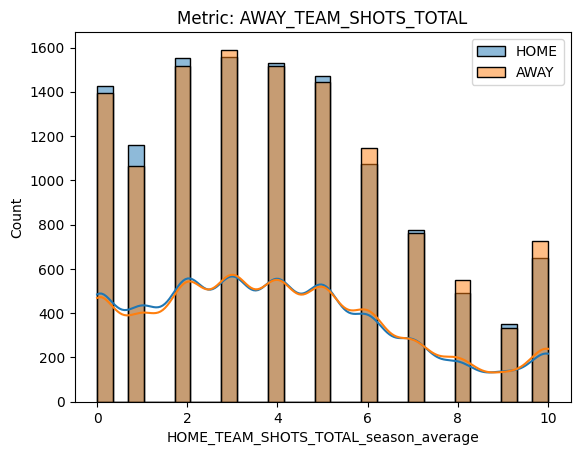

Metric: AWAY_TEAM_SHOTS_TOTAL
Differences: {'l1_loss': {'loss_value': 0.003512672577260764, 'estimated_typical_loss_value': 0.0025990704410601994, 'loss_value_normalized': 1.3515111101904544}, 'l2_loss': {'loss_value': 2.118396285396333e-05, 'estimated_typical_loss_value': 1.2378244140368992e-05, 'loss_value_normalized': 1.7113867373560978}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04377872821451027, 'estimated_typical_loss_value': 0.03146263574324683, 'loss_value_normalized': 1.3914513892532563}}


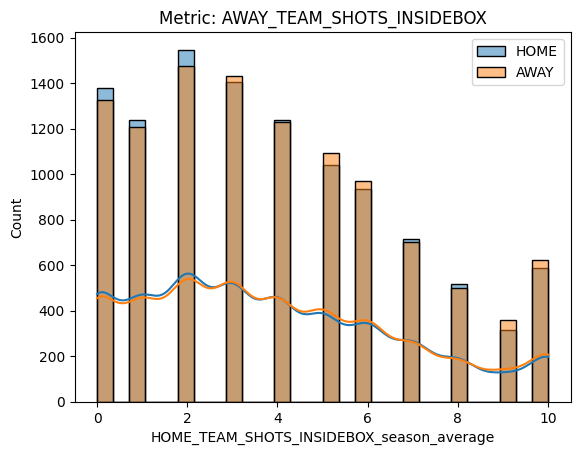

Metric: AWAY_TEAM_SHOTS_INSIDEBOX
Differences: {'l1_loss': {'loss_value': 0.003087637508480163, 'estimated_typical_loss_value': 0.0025745383609319227, 'loss_value_normalized': 1.199297534398456}, 'l2_loss': {'loss_value': 1.4549347049364951e-05, 'estimated_typical_loss_value': 1.2354916839647394e-05, 'loss_value_normalized': 1.1776159433476772}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.037920479184571976, 'estimated_typical_loss_value': 0.032088792827525824, 'loss_value_normalized': 1.1817359222078139}}


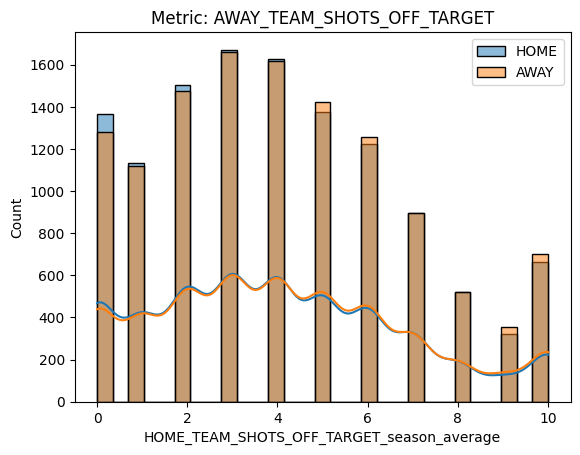

Metric: AWAY_TEAM_SHOTS_OFF_TARGET
Differences: {'l1_loss': {'loss_value': 0.002275867674550921, 'estimated_typical_loss_value': 0.0025136515114569245, 'loss_value_normalized': 0.9054030219294863}, 'l2_loss': {'loss_value': 9.772961826513777e-06, 'estimated_typical_loss_value': 1.2669366931454768e-05, 'loss_value_normalized': 0.7713851749039452}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.027263971270832063, 'estimated_typical_loss_value': 0.03166917053162303, 'loss_value_normalized': 0.8608994429963874}}


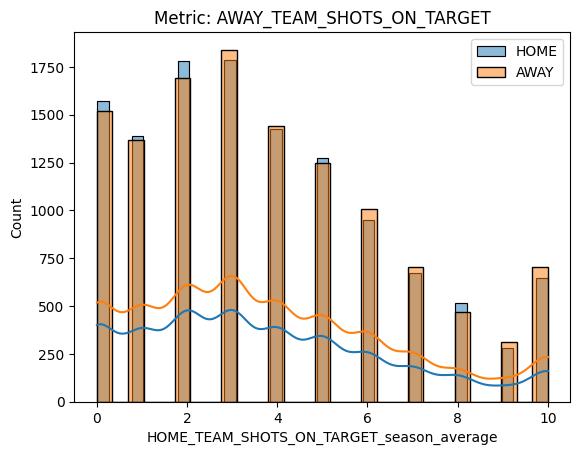

Metric: AWAY_TEAM_SHOTS_ON_TARGET
Differences: {'l1_loss': {'loss_value': 0.0035621641995107578, 'estimated_typical_loss_value': 0.0028098098763790053, 'loss_value_normalized': 1.2677598685435}, 'l2_loss': {'loss_value': 1.6979674864772177e-05, 'estimated_typical_loss_value': 1.3218783722240064e-05, 'loss_value_normalized': 1.2845111336468384}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04785625413345238, 'estimated_typical_loss_value': 0.03301892996182828, 'loss_value_normalized': 1.4493581163525455}}


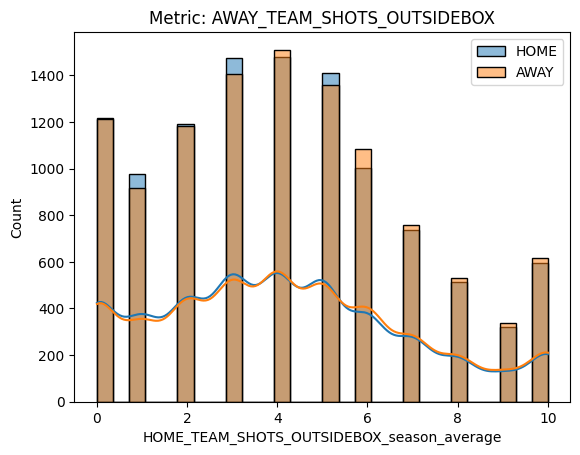

Metric: AWAY_TEAM_SHOTS_OUTSIDEBOX
Differences: {'l1_loss': {'loss_value': 0.003145824331566365, 'estimated_typical_loss_value': 0.00270872588356129, 'loss_value_normalized': 1.1613668074194878}, 'l2_loss': {'loss_value': 1.5390268088897097e-05, 'estimated_typical_loss_value': 1.4406397983333469e-05, 'loss_value_normalized': 1.0682939695588476}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.03346435578747889, 'estimated_typical_loss_value': 0.031222943011550607, 'loss_value_normalized': 1.0717873640258337}}


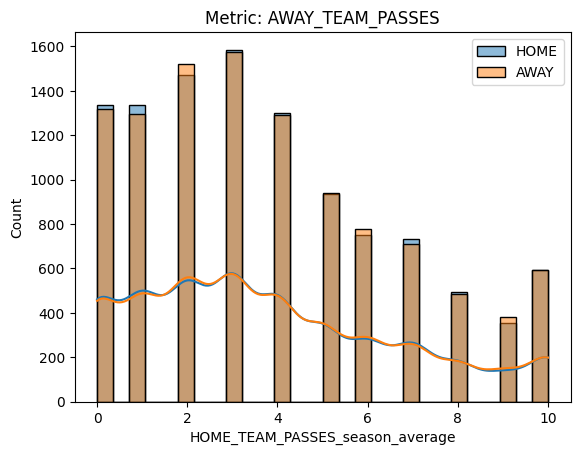

Metric: AWAY_TEAM_PASSES
Differences: {'l1_loss': {'loss_value': 0.001758573860431888, 'estimated_typical_loss_value': 0.002616065556811717, 'loss_value_normalized': 0.6722208684154571}, 'l2_loss': {'loss_value': 5.844543937345799e-06, 'estimated_typical_loss_value': 1.2833775152348936e-05, 'loss_value_normalized': 0.45540332971900055}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.020823023552125404, 'estimated_typical_loss_value': 0.0315794817274104, 'loss_value_normalized': 0.6593845881280331}}


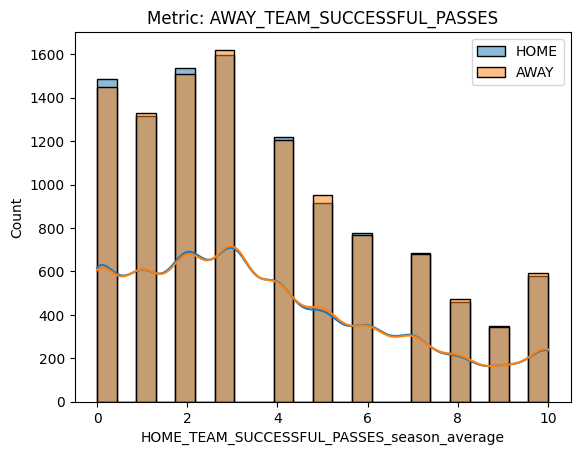

Metric: AWAY_TEAM_SUCCESSFUL_PASSES
Differences: {'l1_loss': {'loss_value': 0.001504185691646393, 'estimated_typical_loss_value': 0.002691287416964081, 'loss_value_normalized': 0.5589093465695583}, 'l2_loss': {'loss_value': 3.2263638887725678e-06, 'estimated_typical_loss_value': 1.2637631231914889e-05, 'loss_value_normalized': 0.25529815117314614}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.01748043460771779, 'estimated_typical_loss_value': 0.032418250481925474, 'loss_value_normalized': 0.5392158536582269}}


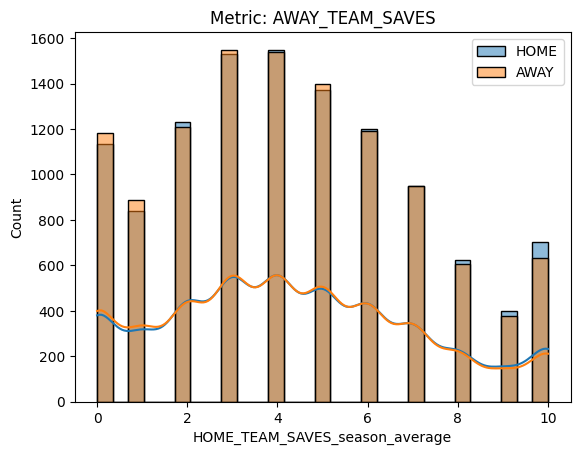

Metric: AWAY_TEAM_SAVES
Differences: {'l1_loss': {'loss_value': 0.0021393795259352995, 'estimated_typical_loss_value': 0.002664981933453039, 'loss_value_normalized': 0.802774495046242}, 'l2_loss': {'loss_value': 1.150840558985e-05, 'estimated_typical_loss_value': 1.2280490498107231e-05, 'loss_value_normalized': 0.9371291473590314}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.02500709093181032, 'estimated_typical_loss_value': 0.031576882825007424, 'loss_value_normalized': 0.791942987862174}}


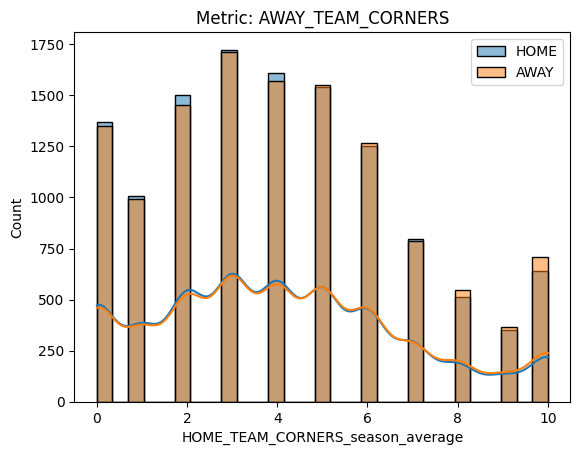

Metric: AWAY_TEAM_CORNERS
Differences: {'l1_loss': {'loss_value': 0.0021282570461565744, 'estimated_typical_loss_value': 0.0026602528577656594, 'loss_value_normalized': 0.8000205844883164}, 'l2_loss': {'loss_value': 7.073814492545204e-06, 'estimated_typical_loss_value': 1.263641802008539e-05, 'loss_value_normalized': 0.5597958599642071}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.029617935968981216, 'estimated_typical_loss_value': 0.03255704680042626, 'loss_value_normalized': 0.9097242802929298}}


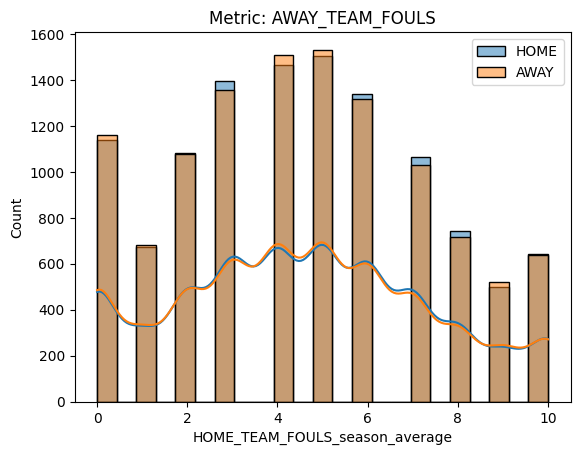

Metric: AWAY_TEAM_FOULS
Differences: {'l1_loss': {'loss_value': 0.0019496506544771962, 'estimated_typical_loss_value': 0.0025916812602986713, 'loss_value_normalized': 0.7522725438283051}, 'l2_loss': {'loss_value': 5.287000269979604e-06, 'estimated_typical_loss_value': 1.2763456914231424e-05, 'loss_value_normalized': 0.4142294916977039}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.0203962282931641, 'estimated_typical_loss_value': 0.02935442447171062, 'loss_value_normalized': 0.694826373203813}}


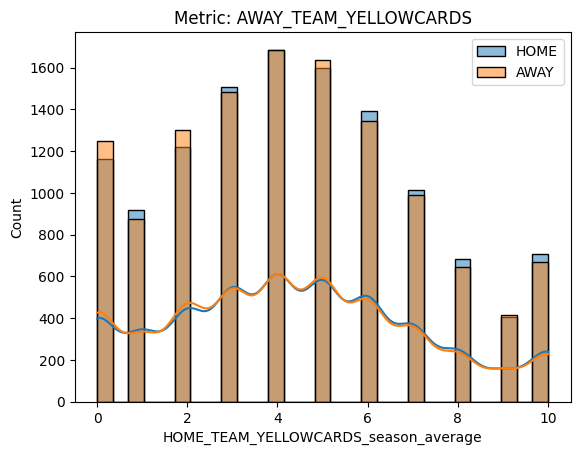

Metric: AWAY_TEAM_YELLOWCARDS
Differences: {'l1_loss': {'loss_value': 0.0024985585239285023, 'estimated_typical_loss_value': 0.002627888246030163, 'loss_value_normalized': 0.9507856841715988}, 'l2_loss': {'loss_value': 9.563316235502389e-06, 'estimated_typical_loss_value': 1.2366244154055468e-05, 'loss_value_normalized': 0.7733404028089171}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.027983882305816887, 'estimated_typical_loss_value': 0.029958595485548224, 'loss_value_normalized': 0.9340852550753213}}


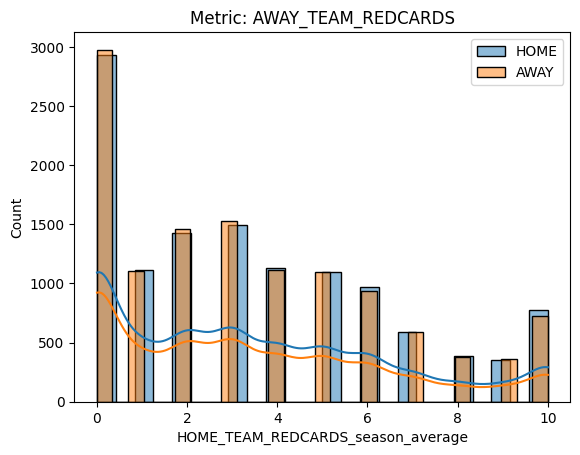

Metric: AWAY_TEAM_REDCARDS
Differences: {'l1_loss': {'loss_value': 0.0016449440200357122, 'estimated_typical_loss_value': 0.002607641890743574, 'loss_value_normalized': 0.6308166876267328}, 'l2_loss': {'loss_value': 4.5923088691088945e-06, 'estimated_typical_loss_value': 1.131390901795001e-05, 'loss_value_normalized': 0.4058993988490511}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.019318427579795416, 'estimated_typical_loss_value': 0.033034193982995584, 'loss_value_normalized': 0.584800936561052}}


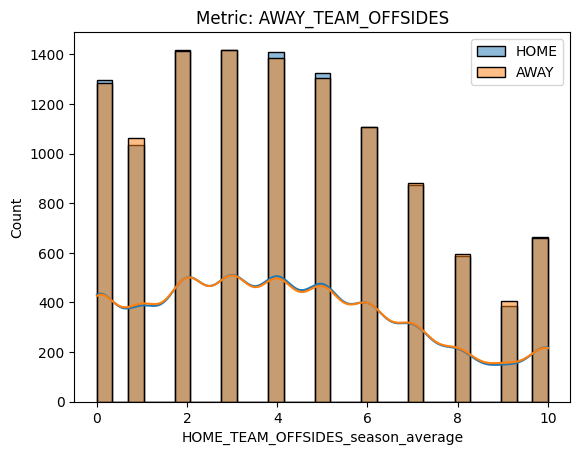

Metric: AWAY_TEAM_OFFSIDES
Differences: {'l1_loss': {'loss_value': 0.0009046377254963875, 'estimated_typical_loss_value': 0.002622420252266631, 'loss_value_normalized': 0.3449629115373126}, 'l2_loss': {'loss_value': 1.408876015301168e-06, 'estimated_typical_loss_value': 1.3381101855427973e-05, 'loss_value_normalized': 0.10528849047705935}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.01269842964503049, 'estimated_typical_loss_value': 0.03142643765239077, 'loss_value_normalized': 0.4040683766161567}}


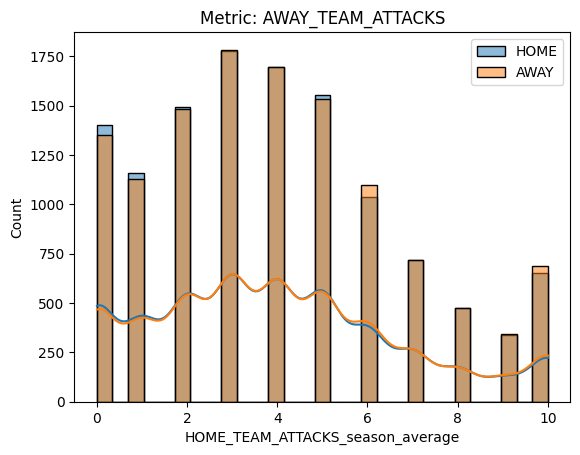

Metric: AWAY_TEAM_ATTACKS
Differences: {'l1_loss': {'loss_value': 0.0016551764905824878, 'estimated_typical_loss_value': 0.0024962130448597164, 'loss_value_normalized': 0.6630750103604875}, 'l2_loss': {'loss_value': 7.006598615296805e-06, 'estimated_typical_loss_value': 1.2925799071415948e-05, 'loss_value_normalized': 0.5420630923058988}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.017736956867216273, 'estimated_typical_loss_value': 0.03056527775556641, 'loss_value_normalized': 0.5802975850263938}}


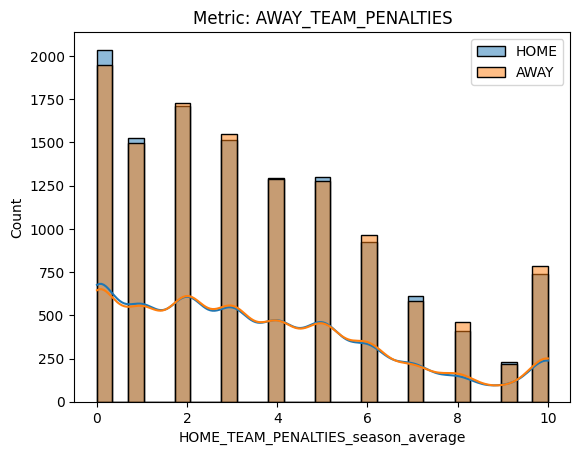

Metric: AWAY_TEAM_PENALTIES
Differences: {'l1_loss': {'loss_value': 0.0027079618517723844, 'estimated_typical_loss_value': 0.0025217796102946066, 'loss_value_normalized': 1.0738297037209326}, 'l2_loss': {'loss_value': 1.375706441380624e-05, 'estimated_typical_loss_value': 1.1612443211994198e-05, 'loss_value_normalized': 1.1846830302975229}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.03610047648802557, 'estimated_typical_loss_value': 0.033936722358662345, 'loss_value_normalized': 1.0637584887101124}}


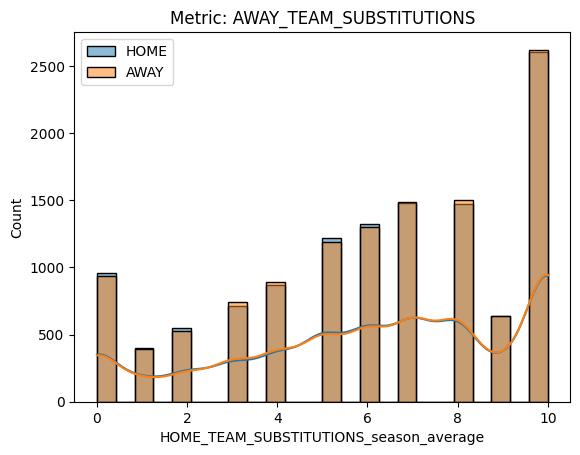

Metric: AWAY_TEAM_SUBSTITUTIONS
Differences: {'l1_loss': {'loss_value': 0.0015158946007401116, 'estimated_typical_loss_value': 0.00267044992721657, 'loss_value_normalized': 0.5676551300551865}, 'l2_loss': {'loss_value': 2.9798740376510132e-06, 'estimated_typical_loss_value': 1.3093774855808738e-05, 'loss_value_normalized': 0.22757944675354877}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.018681214684247563, 'estimated_typical_loss_value': 0.03155061591254711, 'loss_value_normalized': 0.5921030111116864}}


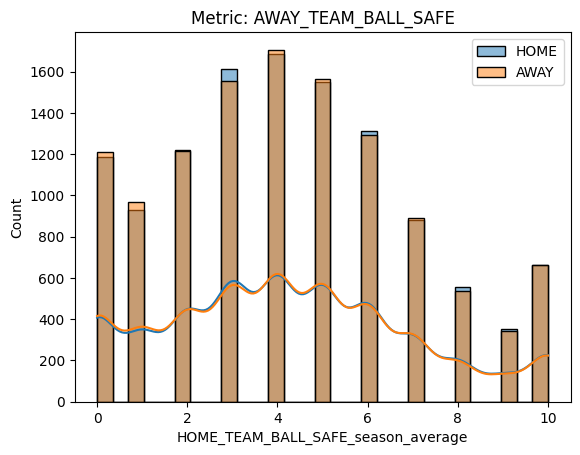

Metric: AWAY_TEAM_BALL_SAFE
Differences: {'l1_loss': {'loss_value': 0.0014537901037647112, 'estimated_typical_loss_value': 0.002764440306503218, 'loss_value_normalized': 0.5258894903046452}, 'l2_loss': {'loss_value': 4.606020232351123e-06, 'estimated_typical_loss_value': 1.1895578024202606e-05, 'loss_value_normalized': 0.38720440678828644}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.01409131661680707, 'estimated_typical_loss_value': 0.03220113141348835, 'loss_value_normalized': 0.43760315238192}}


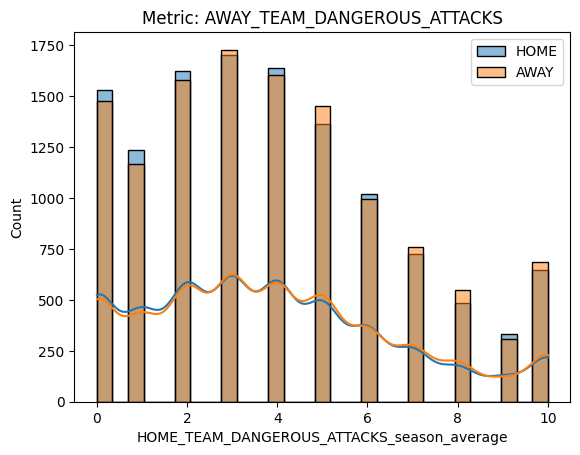

Metric: AWAY_TEAM_DANGEROUS_ATTACKS
Differences: {'l1_loss': {'loss_value': 0.0036945903807644852, 'estimated_typical_loss_value': 0.0026367552629439966, 'loss_value_normalized': 1.4011882075999276}, 'l2_loss': {'loss_value': 2.0783159479147245e-05, 'estimated_typical_loss_value': 1.3268116999306794e-05, 'loss_value_normalized': 1.566398568831227}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.04615355719280668, 'estimated_typical_loss_value': 0.03266925463602956, 'loss_value_normalized': 1.4127520724609839}}


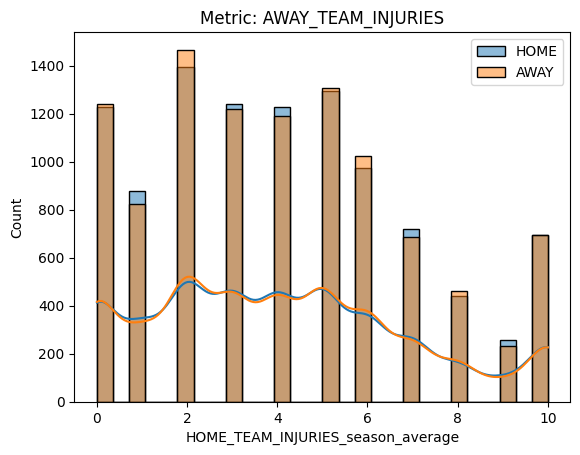

Metric: AWAY_TEAM_INJURIES
Differences: {'l1_loss': {'loss_value': 0.002696538810890781, 'estimated_typical_loss_value': 0.002627888246030162, 'loss_value_normalized': 1.0261238524751188}, 'l2_loss': {'loss_value': 1.089669850985587e-05, 'estimated_typical_loss_value': 1.307208118685756e-05, 'loss_value_normalized': 0.8335855900762096}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.03288565008609457, 'estimated_typical_loss_value': 0.031290820873017114, 'loss_value_normalized': 1.050967957010437}}


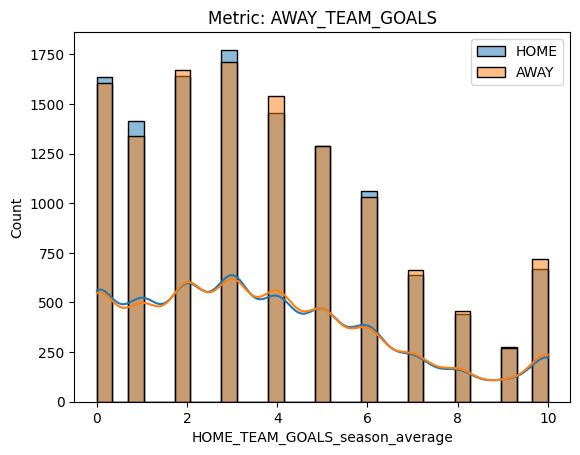

Metric: AWAY_TEAM_GOALS
Differences: {'l1_loss': {'loss_value': 0.0030157662485494, 'estimated_typical_loss_value': 0.00265508043123259, 'loss_value_normalized': 1.135847416550433}, 'l2_loss': {'loss_value': 1.6524838774177863e-05, 'estimated_typical_loss_value': 1.3926326458802432e-05, 'loss_value_normalized': 1.1865899325855247}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.030937152274070324, 'estimated_typical_loss_value': 0.03375540904592625, 'loss_value_normalized': 0.9165094765102173}}


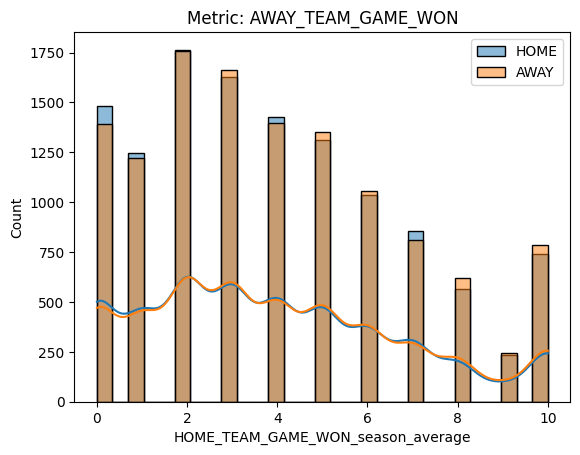

Metric: AWAY_TEAM_GAME_WON
Differences: {'l1_loss': {'loss_value': 0.002957595474878924, 'estimated_typical_loss_value': 0.0026157699895812555, 'loss_value_normalized': 1.130678724298744}, 'l2_loss': {'loss_value': 1.505499087395672e-05, 'estimated_typical_loss_value': 1.1946629017027926e-05, 'loss_value_normalized': 1.2601873593143742}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.0360049260722222, 'estimated_typical_loss_value': 0.032337905795537455, 'loss_value_normalized': 1.1133969620627238}}


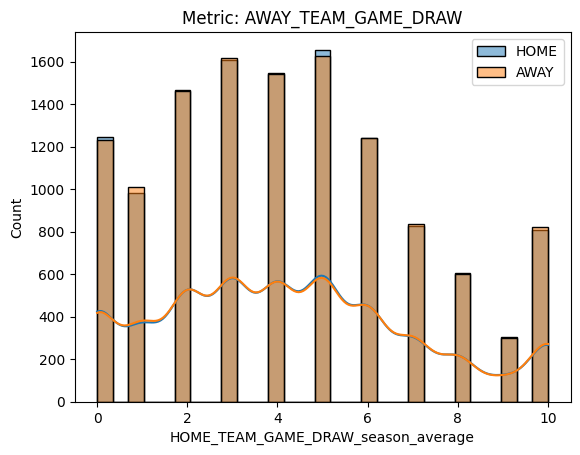

Metric: AWAY_TEAM_GAME_DRAW
Differences: {'l1_loss': {'loss_value': 0.0006214488636363646, 'estimated_typical_loss_value': 0.002720696356394965, 'loss_value_normalized': 0.22841536953420236}, 'l2_loss': {'loss_value': 8.404856980449027e-07, 'estimated_typical_loss_value': 1.3552645203319376e-05, 'loss_value_normalized': 0.06201635809260887}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.007256454509132913, 'estimated_typical_loss_value': 0.03306254501223217, 'loss_value_normalized': 0.21947658616262566}}


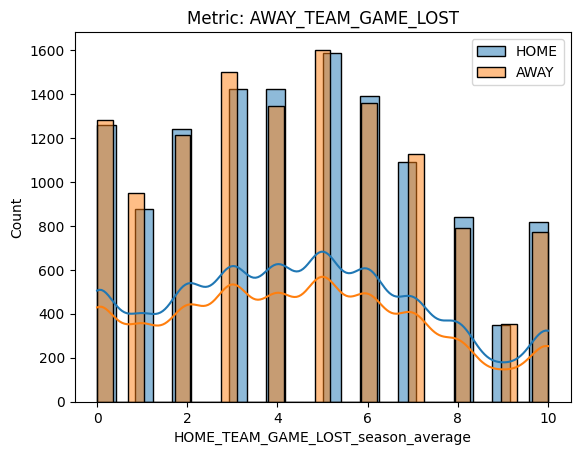

Metric: AWAY_TEAM_GAME_LOST
Differences: {'l1_loss': {'loss_value': 0.0034754573553987898, 'estimated_typical_loss_value': 0.0027749329431845885, 'loss_value_normalized': 1.2524473299199737}, 'l2_loss': {'loss_value': 1.7848305446369575e-05, 'estimated_typical_loss_value': 1.3167312309473826e-05, 'loss_value_normalized': 1.3555010336640085}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.03390751970325766, 'estimated_typical_loss_value': 0.02932921860679626, 'loss_value_normalized': 1.156100343409771}}


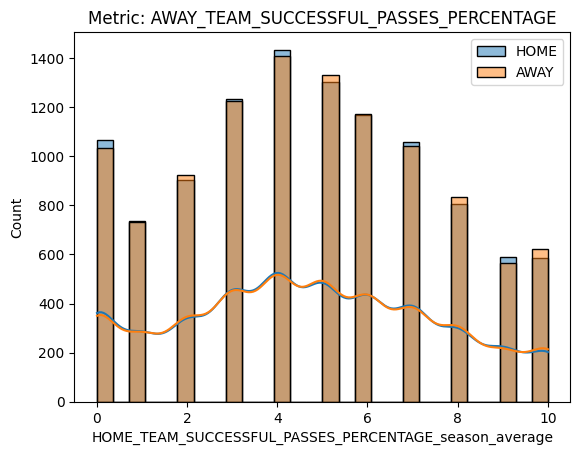

Metric: AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE
Differences: {'l1_loss': {'loss_value': 0.001849974177102147, 'estimated_typical_loss_value': 0.0027285288880021874, 'loss_value_normalized': 0.6780115780472958}, 'l2_loss': {'loss_value': 4.512349481142639e-06, 'estimated_typical_loss_value': 1.3844572798292047e-05, 'loss_value_normalized': 0.3259291237666026}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.02115171856655536, 'estimated_typical_loss_value': 0.029467768832883764, 'loss_value_normalized': 0.7177916552321909}}


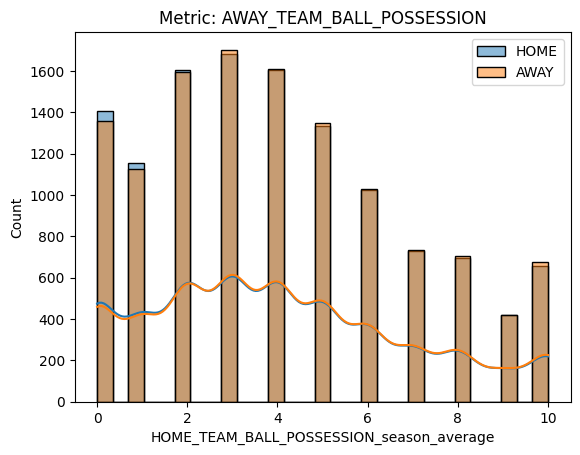

Metric: AWAY_TEAM_BALL_POSSESSION
Differences: {'l1_loss': {'loss_value': 0.0012809246807706566, 'estimated_typical_loss_value': 0.0025041933600821677, 'loss_value_normalized': 0.5115118908902918}, 'l2_loss': {'loss_value': 4.356278389699268e-06, 'estimated_typical_loss_value': 1.2867745083574823e-05, 'loss_value_normalized': 0.3385424844314577}, 'kl_divergence': {'loss_value': nan, 'estimated_typical_loss_value': nan, 'loss_value_normalized': nan}, 'sum_ratio_abs_diff': {'loss_value': 0.011301522162954785, 'estimated_typical_loss_value': 0.03129935080292578, 'loss_value_normalized': 0.3610784847939488}}


In [7]:
from data_analysis import get_metrics_names_to_fn_names, compute_distribution_difference

column_names_to_fn_names = get_metrics_names_to_fn_names(df_teamfeatures)
for metric_name, list_fn_names in column_names_to_fn_names.items():
    # Skip metrics that doesnt have the season_average function (i.e. non-aggregated metrics I believe)
    if 'season_average' not in list_fn_names:
        print(f"Missing season_average for {metric_name}")
        continue
    # Compute the distribution difference
    metric_name_side_agnostic = metric_name[len('HOME_'):]
    column_name_home = f"HOME_{metric_name_side_agnostic}_season_average"
    column_name_away = f"AWAY_{metric_name_side_agnostic}_season_average"
    loss_name_to_loss_values = compute_distribution_difference(
        feature_serie1=df_teamfeatures[column_name_home],
        feature_serie2=df_teamfeatures[column_name_away],
        n_monte_carlo=50,
        n_value_max=10,
        normalization_method='mc_estimated_loss',
        )
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {metric_name}")
    sns.histplot(df_teamfeatures[column_name_home], kde=True, label="HOME")
    sns.histplot(df_teamfeatures[column_name_away], kde=True, label="AWAY")
    plt.legend()
    plt.show()
    print(f"Metric: {metric_name}")
    print(f"Differences: {loss_name_to_loss_values}")   

## Player features

In [11]:
from data_loading import load_dataframe_playersfeatures
df_playersfeatures_home, df_playersfeatures_away = load_dataframe_playersfeatures('train')

Missing season_average for ID
Missing season_average for LEAGUE
Missing season_average for TEAM_NAME
Missing season_average for POSITION
Missing season_average for PLAYER_NAME
PLAYER_PUNCHES HOME distribution vs AWAY distribution difference (loss_value_normalized) : 1.135586863404187 (loss = l1_loss)


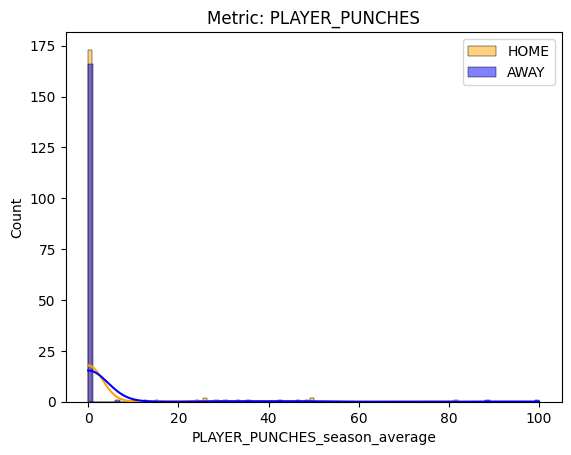

PLAYER_GOALS_CONCEDED HOME distribution vs AWAY distribution difference (loss_value_normalized) : 0.7390062707037852 (loss = l1_loss)


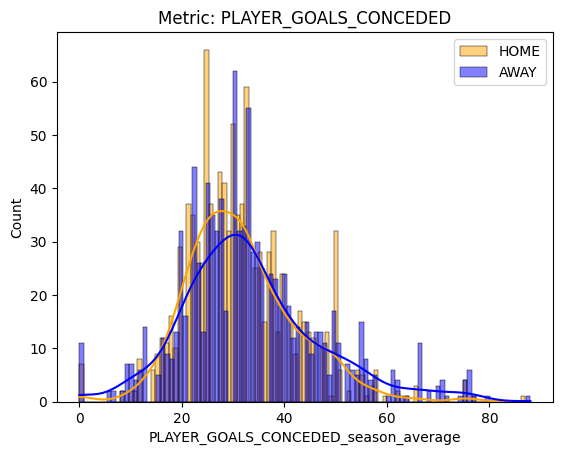

PLAYER_DRIBBLED_ATTEMPTS HOME distribution vs AWAY distribution difference (loss_value_normalized) : 0.6404287984206043 (loss = l1_loss)


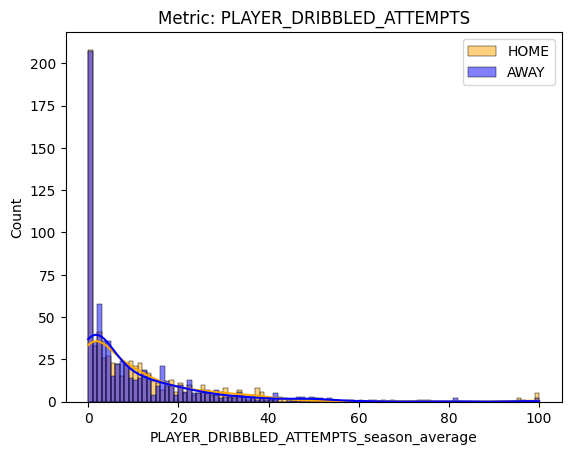

PLAYER_BIG_CHANCES_CREATED HOME distribution vs AWAY distribution difference (loss_value_normalized) : 0.5927759796943372 (loss = l1_loss)


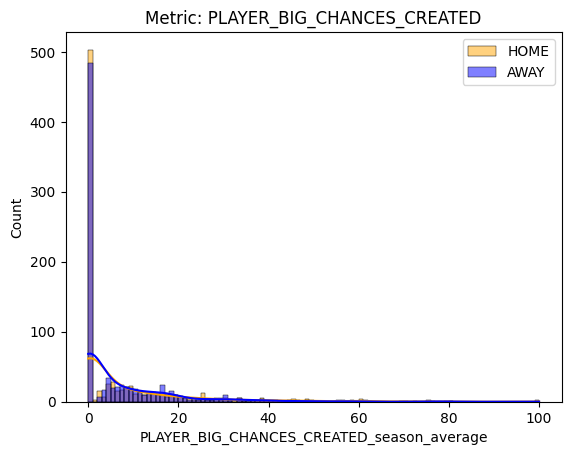

PLAYER_OWN_GOALS HOME distribution vs AWAY distribution difference (loss_value_normalized) : 0.53933055388676 (loss = l1_loss)


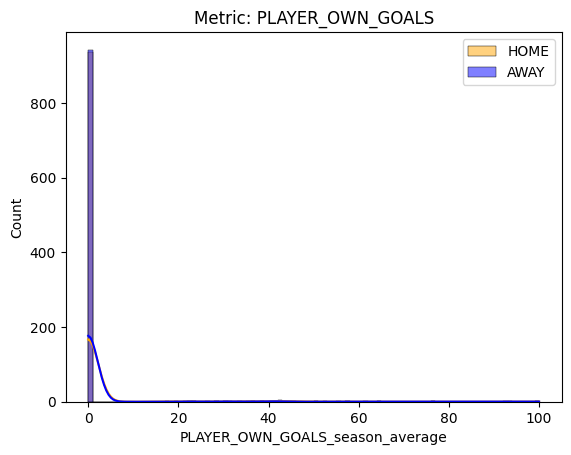

PLAYER_AERIALS_WON HOME distribution vs AWAY distribution difference (loss_value_normalized) : 0.4974987089417515 (loss = l1_loss)


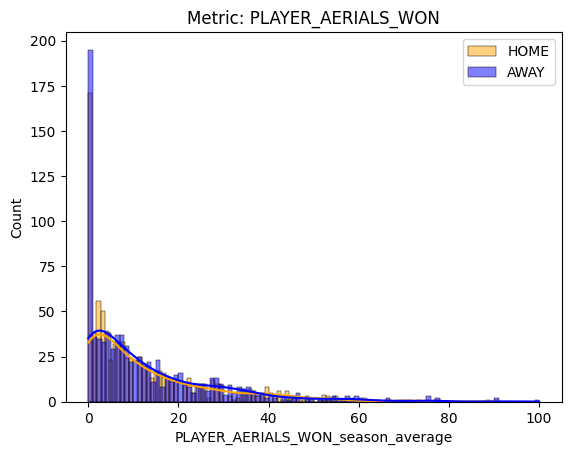

PLAYER_PENALTIES_MISSES HOME distribution vs AWAY distribution difference (loss_value_normalized) : 0.4934959087521886 (loss = l1_loss)


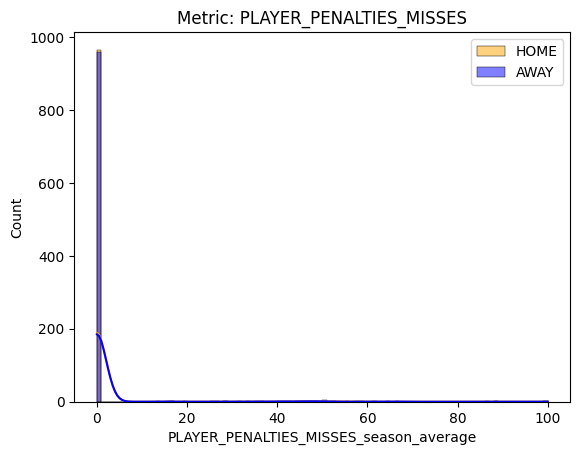

PLAYER_BIG_CHANCES_MISSED HOME distribution vs AWAY distribution difference (loss_value_normalized) : 0.49104257973461546 (loss = l1_loss)


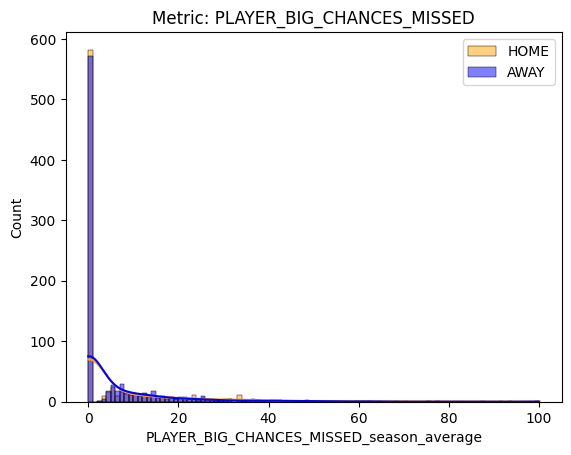

PLAYER_OFFSIDES HOME distribution vs AWAY distribution difference (loss_value_normalized) : 0.48516441447596853 (loss = l1_loss)


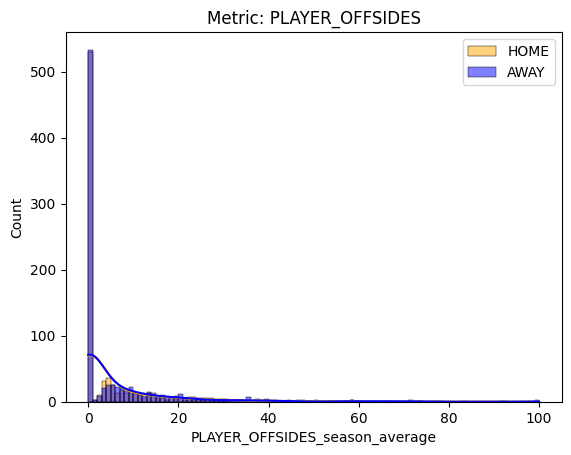

PLAYER_REDCARDS HOME distribution vs AWAY distribution difference (loss_value_normalized) : 0.46926490825264233 (loss = l1_loss)


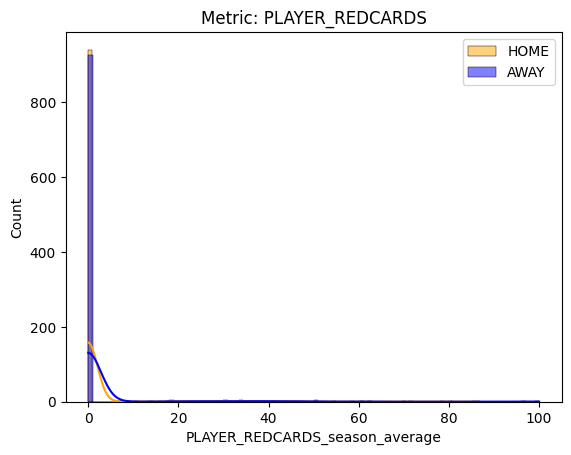

In [22]:
from data_analysis import get_metrics_names_to_fn_names, compute_distribution_difference, loss_name_to_loss_fn

column_names_to_fn_names = get_metrics_names_to_fn_names(df_playersfeatures_home)
metric_name_to_loss_name_to_loss_values : Dict[str, Dict[str, float]] = {}
for metric_name, list_fn_names in column_names_to_fn_names.items():
    
    # Skip metrics that doesnt have the season_average function (i.e. non-aggregated metrics I believe)
    if 'season_average' not in list_fn_names:
        print(f"Missing season_average for {metric_name}")
        continue
    
    column_name = f"{metric_name}_season_average"
    
    # Compute the distribution difference
    metric_name_to_loss_name_to_loss_values[metric_name] = compute_distribution_difference(
        feature_serie1=df_playersfeatures_home[column_name],
        feature_serie2=df_playersfeatures_away[column_name],
        n_monte_carlo=100,
        n_value_max=100,
        normalization_method='mc_estimated_loss',
        )

# Print top differences
LOSS_NAME = 'l1_loss'
assert LOSS_NAME in loss_name_to_loss_fn.keys(), f"{LOSS_NAME} not in {loss_name_to_loss_fn.keys()}"
LOSS_STATISTIC = 'loss_value_normalized'
assert LOSS_STATISTIC in ['loss_value', 'loss_value_normalized', 'estimated_typical_loss_value']
n_top_metrics_to_plot = 10

for metric_name, loss_name_to_loss_values in sorted(metric_name_to_loss_name_to_loss_values.items(), key = lambda x : x[1][LOSS_NAME][LOSS_STATISTIC], reverse=True)[:n_top_metrics_to_plot]:
    print(f"{metric_name} HOME distribution vs AWAY distribution difference ({LOSS_STATISTIC}) : {loss_name_to_loss_values[LOSS_NAME][LOSS_STATISTIC]} (loss = {LOSS_NAME})")
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {metric_name}")
    column_name = f"{metric_name}_season_average"
    sns.histplot(df_playersfeatures_home[column_name], kde=True, label="HOME", bins=100, color="orange")
    sns.histplot(df_playersfeatures_away[column_name], kde=True, label="AWAY", bins=100, color="blue")
    plt.legend()
    plt.show()